### Toxic Comment Classification

<b>Objective</b>: To build a model that is capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. The data is comments collected from Wikipedia’s talk page edits. The model will help classify toxic comments into different categories by means of which we can have an healthy and productive online discussions.

<b>Approach</b>: The overall approach can be divided into two subsections:
1. Using traditional ML algorithms on embedded text from pre-trained models (HuggingFace sentence transformers)
2. Using Keras Tokenizer, Embedding techiques and building a LSTM model

#### 1. Loading Packages

In [23]:
# To handle Data and Basic Ops
import pandas as pd
import numpy as np

# Text Preprocessing
import preprocessor as p
import string
import re
from bs4 import BeautifulSoup
from html import unescape

# Misc
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["figure.figsize"] = (10,5)

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Hugging Face Sentence Transformer
from sentence_transformers import SentenceTransformer

# Traditional Classifiers
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Keras API for LSTM and Text Processing
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 2. Loading Data

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [25]:
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [26]:
test.head(3)

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """


#### 3. Text Preprocessing 
<b>Comment Cleaning and Preparation</b>

1. Remove URLs, Numbers, Mentions, Reserved Keywords, Smiley, and other irrevalent numbers.
2. Remove Punctuations, numbers.
3. Lemmatization.

In [27]:
def processing_sentence(df):
    
    # Beautiful Soup parses and converts encoded text to actual symbols. 
    # For example it decodes and replaces similey with actaul symbol.
    df['processed_comment'] = df['comment_text'].apply(lambda x : BeautifulSoup(unescape(x), 'lxml').text)

    # Preprocessor removes URLs, EMOJI, Mentions, Reserved Keywords, Smiley Numbers etc
    p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.SMILEY, p.OPT.NUMBER)
    df['processed_comment'] = df['processed_comment'].apply(lambda x: p.clean(x))

    # Remove Punctuations
    df['processed_comment'] = df['processed_comment'].apply(lambda x: "".\
                                                            join([char for char in x if char not in string.punctuation]))

    # Lower case all the words and numbers
    df['processed_comment'] = df['processed_comment'].apply(lambda x : x.lower())
    df['processed_comment'] = df['processed_comment'].str.replace("[\d-]",'',regex=True)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()   
    df['processed_comment'] = df['processed_comment'].apply(lambda x:[lemmatizer.lemmatize(word, pos = "v") for word in x])
    df['processed_comment'] = df['processed_comment'].apply(lambda x: "".join(x))
    
    return df['processed_comment']

In [28]:
%%time
train['processed_comment'] = processing_sentence(train[['comment_text']])
test['processed_comment'] = processing_sentence(test[['comment_text']])

In [30]:
train[train['toxic']==1].head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_comment
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksucker before you piss around on my work
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0,hey what is it talk what is it an exclusive group of some wp talibanswho are good at destroying selfappointed purist who gang up any one who asks them questions abt their antisocial and destructive noncontribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings


In [31]:
test.head(2)

,id,comment_text,processed_comment
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",yo bitch ja rule is more succesful then youll ever be whats up with you and hating you sad mofuckasi should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother toofuckin white boys get things right next time
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO.",from rfc the title is fine as it is imo


#### 4. Data Exploration

In [32]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<AxesSubplot:>

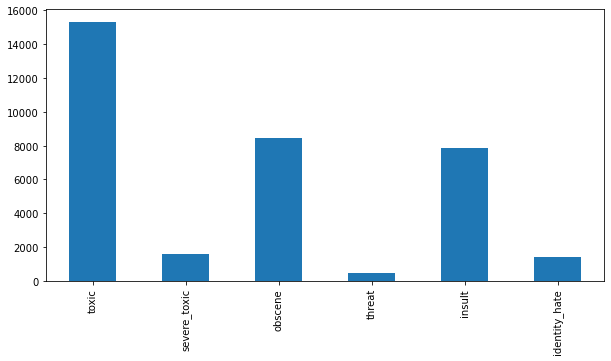

In [33]:
train[labels].sum().plot(kind = 'bar')

In [290]:
train[labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

There are very few observations corresponding to the threat label. Typically with numerical data, we synthesize by upsampling the minority class. Since the data is text, ideally we would want to have more example texts in the threat category. 

<AxesSubplot:>

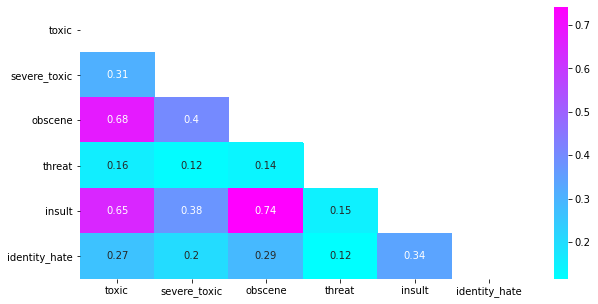

In [34]:
# Correlation matrix - labels
corr = train[labels].corr()
matrix = np.triu(corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="cool", mask=matrix)

We observe a positive correlation between Obscene, Insult and Toxic comments. Other classes don't show any direct strong correlation. 

In [35]:
def WordCloudGenerater(label):
    comment = train[train[label] == 1]['processed_comment']
    word = pd.Series(comment).str.cat(sep=' ')
    wordcloud = WordCloud(width=1000, height=500, max_font_size=150).generate(word)
    plt.imshow(wordcloud.recolor(colormap="cool"), interpolation='bilinear')
    plt.axis("off")
    plt.show()

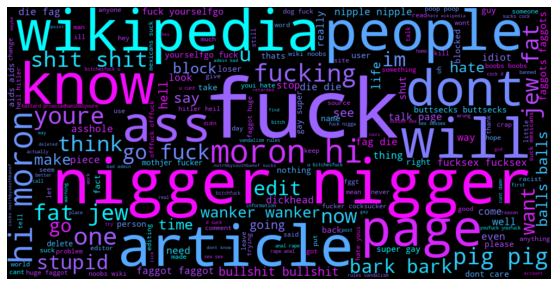

In [36]:
WordCloudGenerater('toxic')

The word cloud helps visualize the most frequent words appearing with in each category. However, this doesn't directly mean that the appearing words directly contribute towards the sentence being classified in certain category. For example, know, people, article are neutral words. 

#### Models

#### 5.1 Modeling using Sentence Transformer
1. XGBoost
2. Logistic Regression

In [46]:
%%time
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Wall time: 5.15 s


In [49]:
%%time
train_embedding = model.encode(train['processed_comment'])

Wall time: 34min 42s


In [50]:
%%time
test_embedding = model.encode(test['processed_comment'])

Wall time: 36min 40s


In [57]:
# Outputing the above embedding to avoid reruns

# train_embedding = pd.DataFrame(train_embedding)
# test_embedding = pd.DataFrame(test_embedding)
# train_embedding.to_csv('train_embeadding.csv',index=False)
# test_embedding.to_csv('test_embedding.csv',index=False)

In [61]:
print("Training Data Shape: ",train_embedding.shape)
print("Testing Data Shape: ",test_embedding.shape)

Training Data Shape:  (159571, 384)
Testing Data Shape:  (153164, 384)


In [78]:
X_train, X_val, Y_train, Y_val = train_test_split(train_embedding,train[labels], test_size=0.25, random_state=42)

In [88]:
Y_predicton = pd.DataFrame()
for label in labels:
    xgb = XGBClassifier()
    xgb.fit(X_train, Y_train[label])
    y_pred = pd.DataFrame(xgb.predict_proba(X_val))[1]
    Y_predicton[label] = y_pred

[13:02:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [113]:
print("XGBoost ROC AUC Score: ",np.round(roc_auc_score(Y_val,Y_predicton),4))

XGBoost ROC AUC Score:  0.9647


In [197]:
Y_predicton = pd.DataFrame()
for label in labels:
    lr = LogisticRegression()
    lr.fit(X_train, Y_train[label])
    y_pred = pd.DataFrame(lr.predict_proba(X_val))[1]
    Y_predicton[label] = y_pred

In [198]:
print("Logistic Regression ROC AUC Score: ",np.round(roc_auc_score(Y_val,Y_predicton),4))

Logistic Regression ROC AUC Score:  0.9718


#### 5.2 LSTM Model

In [286]:
X_train, X_val, Y_train, Y_val = train_test_split(train['processed_comment'], train[labels], random_state=42, test_size=0.25)

In [275]:
max_feature = 100000

tokenizer = Tokenizer(num_words = max_feature)
tokenizer.fit_on_texts(list(X_train))
tokenized_train = tokenizer.texts_to_sequences(X_train)

tokenizer.fit_on_texts(list(X_val))
tokenized_test = tokenizer.texts_to_sequences(X_val)

tokenizer.fit_on_texts(list(test['processed_comment']))
tokenizer_test_data = tokenizer.texts_to_sequences(list(test['processed_comment']))

##### Determining the maximum padding

In [209]:
train['processed_comment_len'] = train['processed_comment'].apply(lambda x : len(x.split()))

<AxesSubplot:xlabel='processed_comment_len', ylabel='Density'>

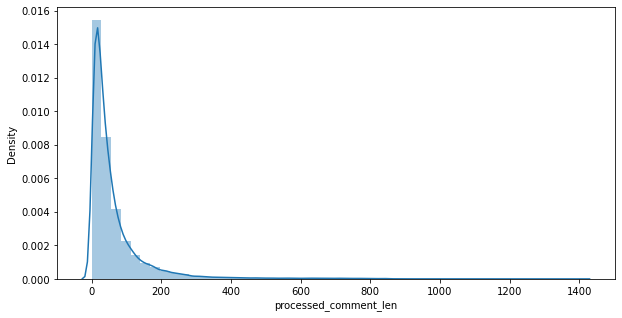

In [211]:
sns.distplot(train['processed_comment_len'])

In [295]:
maxlen = 600
X_train = pad_sequences(tokenized_train, maxlen = maxlen)
X_val = pad_sequences(tokenized_test, maxlen = maxlen)
X_test = pad_sequences(tokenizer_test_data, maxlen = maxlen)

##### Building LSTM Model

In [264]:
maxlen = 600
max_feature = 200000

input = Input(shape = (maxlen,))
embed_size = 128
x = Embedding(max_feature, embed_size)(input)

x = LSTM(60, return_sequences = True, name = "lstm_layer")(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.1)(x)

x = Dense(30, activation = "relu")(x)

x = Dropout(0.1)(x)

x = Dense(6, activation = "sigmoid")(x)

model = Model(inputs = input, outputs = x)
model.compile(loss = "binary_crossentropy",
             optimizer = "adam",
             metrics = ["AUC"])

model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 600)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 600, 128)          25600000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 600, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_21 (Dropout)         (None, 30)                0  

In [265]:
%%time
batch_size = 128
epochs = 3
model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

Epoch 1/3
842/842 [==============================] - 791s 939ms/step - loss: 0.1373 - auc: 0.8096 - val_loss: 0.0616 - val_auc: 0.9747
Epoch 2/3
842/842 [==============================] - 759s 901ms/step - loss: 0.0528 - auc: 0.9776 - val_loss: 0.0513 - val_auc: 0.9816
Epoch 3/3
842/842 [==============================] - 771s 916ms/step - loss: 0.0425 - auc: 0.9864 - val_loss: 0.0521 - val_auc: 0.9776
Wall time: 38min 41s


#### Conclusion

The Logistic Regression models seems to perform in par with the LSTM model. Logistic Regression's performance makes sense as we used text embedding using pre-trained sentence transformer model from HuggingFace.